### Define Circuit

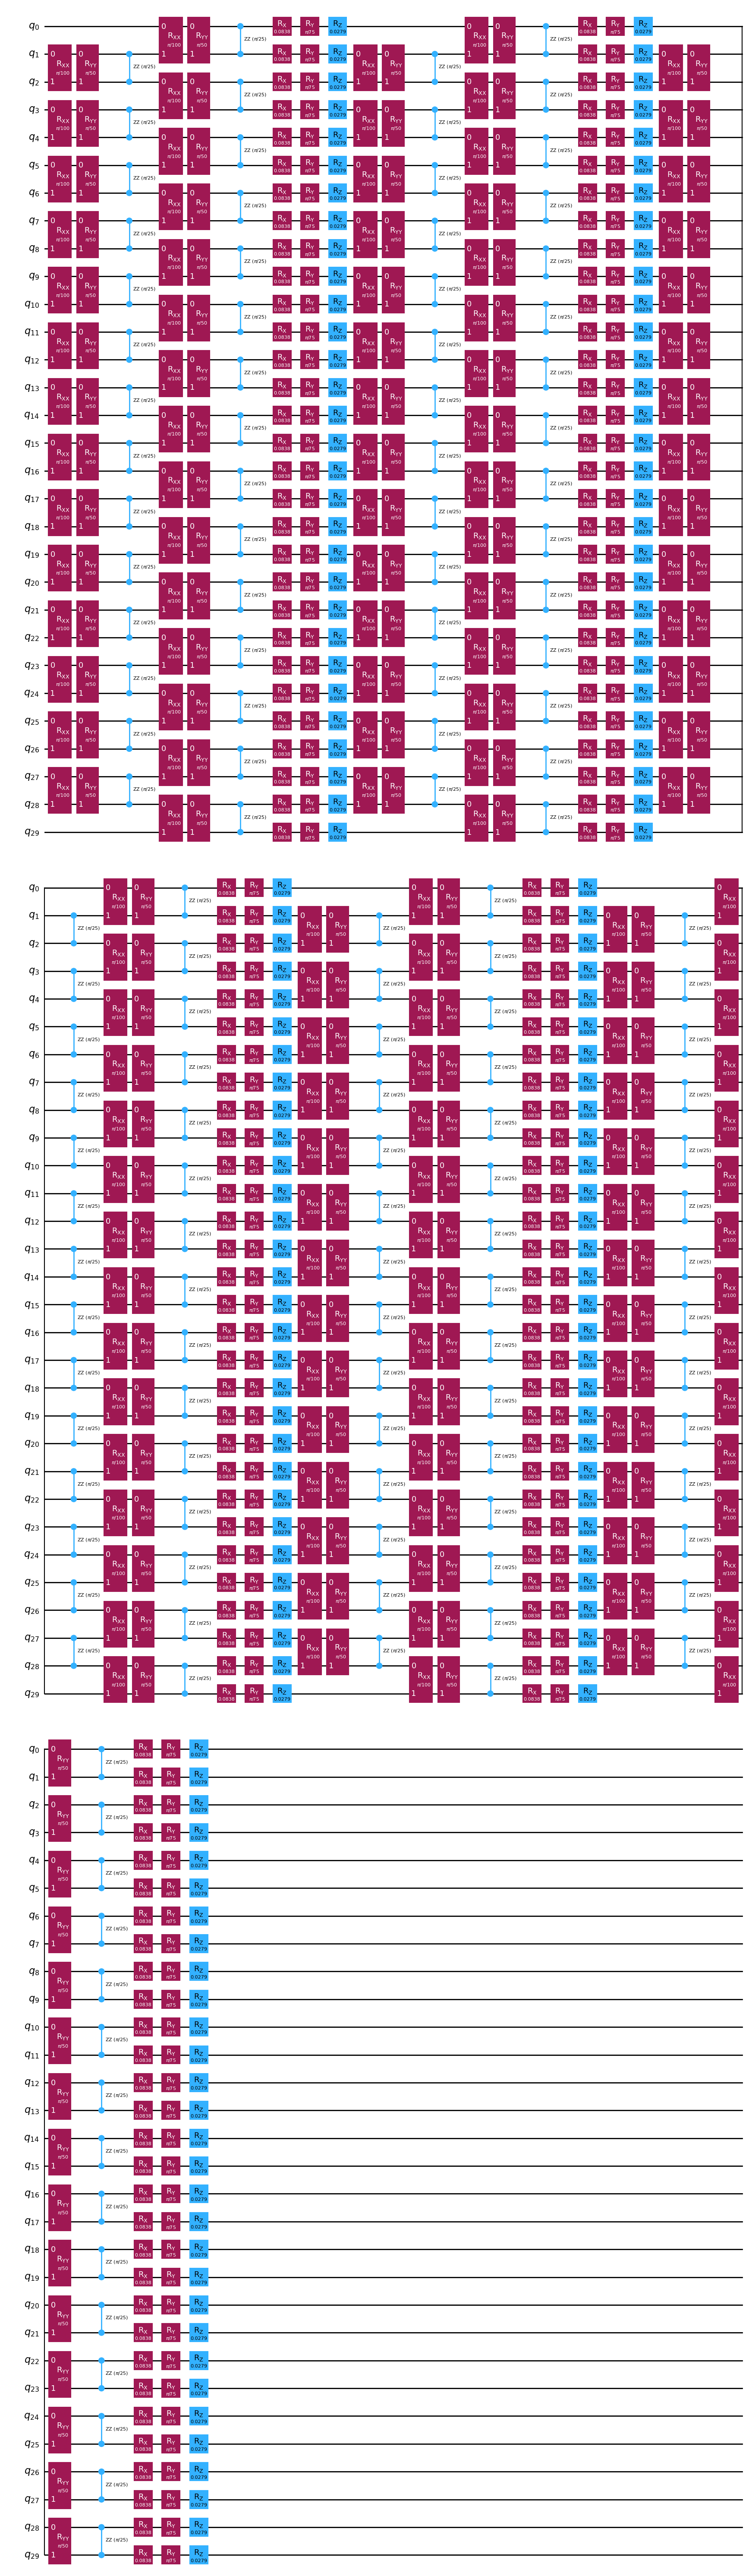

In [19]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2, FakeTorino
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


n = 30  # number of qubits

edges = [(i, i+1) for i in range(n - 1)]

coupling_map = CouplingMap(edges)

#trot_steps=5
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

circuit = generate_time_evolution_circuit(
    hamiltonian, 
    synthesis=LieTrotter(reps=5), 
    time=0.2
    )

    

circuit.draw("mpl") 




### Define Observable

In [20]:
# Specify a single-qubit observable
n=circuit.num_qubits
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZI',

### Define Backend

In [21]:
service=QiskitRuntimeService(channel="ibm_cloud",token="n2Om3bZ5WlEvUWi6-Sudcxj5T_-vy3Ynj8-RrHnNU2Ca")
backend = service.least_busy(operational=True, simulator=False)
backend
#backend=FakeTorino()

account.resolve_crn:WARNING:2025-06-25 14:17:54,526: Multiple CRN values found for service name None: ['crn:v1:bluemix:public:quantum-computing:eu-de:a/6c63dae5281147f1a0449b36e0aaba3a:a1eac29a-e646-40b9-b0ce-8eb6ce6e020a::', 'crn:v1:bluemix:public:quantum-computing:eu-de:a/6c63dae5281147f1a0449b36e0aaba3a:14fecd7a-ce9d-4be1-a40e-02c3a5dd25cf::', 'crn:v1:bluemix:public:quantum-computing:eu-de:a/6c63dae5281147f1a0449b36e0aaba3a:57328bd5-d7b9-4228-8b61-d93627893a9b::', 'crn:v1:bluemix:public:quantum-computing:eu-de:a/6c63dae5281147f1a0449b36e0aaba3a:410f0be9-c050-4c90-8b9b-822790d68495::', 'crn:v1:bluemix:public:quantum-computing:us-east:a/6c63dae5281147f1a0449b36e0aaba3a:dbe5b217-5192-407c-9420-7cd07af41e3e::', 'crn:v1:bluemix:public:quantum-computing:us-east:a/6c63dae5281147f1a0449b36e0aaba3a:068b8d3f-2983-4154-822a-f19a296847ec::', 'crn:v1:bluemix:public:quantum-computing:us-east:a/6c63dae5281147f1a0449b36e0aaba3a:20efd56a-3db0-4aa6-9c69-2686147fcb87::', 'crn:v1:bluemix:public:quantum

<IBMBackend('ibm_strasbourg')>

In [22]:
truncation_error_budget_list =[] # The list of errors to be used 
max_error_per_slice_list = np.linspace(0.0001,0.0127,20)
for error in max_error_per_slice_list:
    trunc_budget = setup_budget(max_error_per_slice=error)
    truncation_error_budget_list.append(trunc_budget)
print(truncation_error_budget_list)

[TruncationErrorBudget(per_slice_budget=[np.float64(0.0001)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0007631578947368421)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0014263157894736842)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.002089473684210526)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.002752631578947368)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.00341578947368421)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.004078947368421053)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.004742105263157895)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.005405263157894

In [5]:
#truncation_error_budget_list[:13]

In [23]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)

### Synthesize circ0, the original experiment (Synthesized circuit with no OBP)

In [24]:
circ0 = pm.run(circuit)
print(" The depth of the circuit with no OBP is : ",circ0.depth(lambda x:x[0].num_qubits==2) )

 The depth of the circuit with no OBP is :  30


/var/folders/tn/sxmbbhqd03lc2zx_q4nzlqrw0000gn/T/ipykernel_27779/2735906442.py:2: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  print(" The depth of the circuit with no OBP is : ",circ0.depth(lambda x:x[0].num_qubits==2) )


In [25]:
# Define an operator budget
op_budget = OperatorBudget(max_qwc_groups=8)

# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(circ0, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

Slice_by_depth separated the circuit into 133 slices.


### Define circ1, the backpropagated circuit with no truncation

In [26]:
# Backpropagate without the truncation error budget
backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
)
# Recombine the slices remaining after backpropagation
circ1 = combine_slices(remaining_slices, include_barriers=False)

print(f"Depth of the backpropagated circuit with no truncation is: ", circ1.depth())

Depth of the backpropagated circuit with no truncation is:  115


## Define circ2 to circ20

In [27]:
truncated_circs = []
truncated_circs_two_qubit_depth = []
truncated_observables=[]
# Backpropagate *with* the truncation error budget
for err in truncation_error_budget_list[:18]:
    backpropagated_observable_trunc, remaining_slices_trunc, metadata_trunc = backpropagate(
            observable,
            synthesized_slices,
            operator_budget=op_budget,
            truncation_error_budget=err,
        )

# Recombine the slices remaining after backpropagation
    bp_circuit_trunc = combine_slices(
        remaining_slices_trunc, include_barriers=False
    )
    if bp_circuit_trunc != None:
        truncated_circs.append(bp_circuit_trunc)
        truncated_circs_two_qubit_depth.append(bp_circuit_trunc.depth(lambda x:x[0].num_qubits==2))
    else:
        bp_circuit_trunc =QuantumCircuit(circuit.num_qubits)
        truncated_circs.append(bp_circuit_trunc)
        truncated_circs_two_qubit_depth.append(bp_circuit_trunc.depth(lambda x:x[0].num_qubits==2))
    truncated_observables.append(backpropagated_observable_trunc) # truncated observables appended
print(truncated_circs)
    #bp_circuit_trunc.draw("mpl")
#print(truncated_observables)




for truncated_circ in truncated_circs:
    if truncated_circ != None:
        print(f"Depth of the truncated backpropagated circuit is: ", truncated_circ.depth())
    else:
        print(f"Depth of the truncated backpropagated circuit is: ", 0)

print(f"The truncated circuits' two-qubit depths are: ",truncated_circs_two_qubit_depth)


/var/folders/tn/sxmbbhqd03lc2zx_q4nzlqrw0000gn/T/ipykernel_27779/1416284864.py:19: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  truncated_circs_two_qubit_depth.append(bp_circuit_trunc.depth(lambda x:x[0].num_qubits==2))


[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x309777b00>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11febd100>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12c118800>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3097778c0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x309706150>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3097043e0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x11ff91fa0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3096e1880>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3096e0bf0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x30989a390>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3096e3b00>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x30989ba70>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3096e2db0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x3098e7680>, <qiskit.circuit.qua

In [28]:
truncated_circs_two_qubit_depth

[26, 25, 24, 22, 22, 19, 25, 22, 25, 22, 22, 19, 19, 22, 13, 0, 10, 0]

In [29]:
truncated_circs_isa=[]
observable_truncated_circs_isa =[]
truncated_circuit_depths = []
pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)

circ0_isa =pass_manager.run(circ0)
observable_isa_circ0 = observable.apply_layout(circ0_isa.layout)
truncated_circuit_depths.append(circ0_isa.depth(lambda x:x[0].num_qubits==2))
circ1_isa =pass_manager.run(circ1)
observable_isa_circ1 = backpropagated_observable.apply_layout(circ1_isa.layout)
truncated_circuit_depths.append(circ1_isa.depth(lambda x:x[0].num_qubits==2))
for ckt,trunc_obs in zip(truncated_circs,truncated_observables):
        truncated_circ_isa = pass_manager.run(ckt)
        observable_isa_trunc_circ = trunc_obs.apply_layout(truncated_circ_isa.layout)
        truncated_circs_isa.append(truncated_circ_isa)
        observable_truncated_circs_isa.append(observable_isa_trunc_circ)

for truncated_ckt in truncated_circs_isa:
    if truncated_ckt != None:
        depth = truncated_ckt.depth(lambda x:x[0].num_qubits==2)
        truncated_circuit_depths.append(depth)
    else:
        truncated_circuit_depths.append(0)

print(truncated_circuit_depths)

/var/folders/tn/sxmbbhqd03lc2zx_q4nzlqrw0000gn/T/ipykernel_27779/238109098.py:8: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  truncated_circuit_depths.append(circ0_isa.depth(lambda x:x[0].num_qubits==2))
/var/folders/tn/sxmbbhqd03lc2zx_q4nzlqrw0000gn/T/ipykernel_27779/238109098.py:11: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  truncated_circuit_depths.append(circ1_isa.depth(lambda x:x[0].num_qubits==2))


[30, 26, 26, 25, 24, 22, 22, 19, 25, 22, 25, 22, 22, 19, 19, 22, 13, 0, 10, 0]


/var/folders/tn/sxmbbhqd03lc2zx_q4nzlqrw0000gn/T/ipykernel_27779/238109098.py:20: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  depth = truncated_ckt.depth(lambda x:x[0].num_qubits==2)


In [30]:
truncated_circuit_depths

[30, 26, 26, 25, 24, 22, 22, 19, 25, 22, 25, 22, 22, 19, 19, 22, 13, 0, 10, 0]

In [31]:
estimator_ideal = EstimatorV2(mode=AerSimulator())
result_ideal =(
    estimator_ideal.run([(circ0, observable)]).result()[0].data.evs.item()
)
print("The ideal expectation value is : ", result_ideal)

The ideal expectation value is :  0.8942708333333333


In [32]:
job =[]
with Batch(backend=backend) as batch:
    estimator=EstimatorV2(mode=batch)
    pub0 = (circ0_isa,observable_isa_circ0)
    job0=estimator.run([pub0,pub0,pub0,pub0,pub0])
    job.append(job0)

    pub1 = (circ1_isa,observable_isa_circ1)
    job1=estimator.run([pub1,pub1,pub1,pub1,pub1])
    job.append(job1)

    for circ_err,obs_err in zip(truncated_circs_isa, observable_truncated_circs_isa):
        puberr= (circ_err,obs_err)
        job_err = estimator.run([puberr,puberr,puberr,puberr,puberr])
        job.append(job_err)

In [39]:
batch_id = batch.session_id
print(batch_id)

cc9c72f1-d8a9-4584-86f5-9b5ad478cd4f


In [45]:
batch.status()

'Closed'

In [46]:
job[0].result()[0].data.evs.item()

0.594698214602614

In [47]:
exp_vals = []
for j in job:
    exp_vals.append((j.result()[0].data.evs.item(),
                      j.result()[1].data.evs.item(),
                      j.result()[2].data.evs.item(),
                      j.result()[3].data.evs.item(),
                      j.result()[4].data.evs.item()))
print(exp_vals)

[(0.594698214602614, 0.5886720198965009, 0.5884183402414799, 0.5950460628610691, 0.5930142378643232), (0.5985250297141504, 0.5995305927807724, 0.5980667505516228, 0.5996965037261789, 0.6039849967829021), (0.6054566545259613, 0.6040140021765087, 0.602150823985734, 0.600579098868065, 0.595763136102292), (0.6573097471941433, 0.6492693522418616, 0.6526888405442196, 0.654960070030419, 0.6510386322215636), (0.6416936781868732, 0.6413765793603874, 0.6263719236344437, 0.637213333983174, 0.6407166749058573), (0.6529088800166765, 0.6551820330025415, 0.6464045109200107, 0.644114176579342, 0.6456037346070248), (0.6520893914386992, 0.6496535527155566, 0.6511076960540597, 0.6527244615375846, 0.6546748346702702), (0.6640273378361696, 0.667955442043757, 0.6690343874317288, 0.6690954305423193, 0.6704902483066865), (0.6331292981653315, 0.6365083980669595, 0.6346487404012907, 0.6335572856138587, 0.6315057590851831), (0.6531934682090741, 0.6513552602371485, 0.6518651647013602, 0.6534480672422711, 0.649474

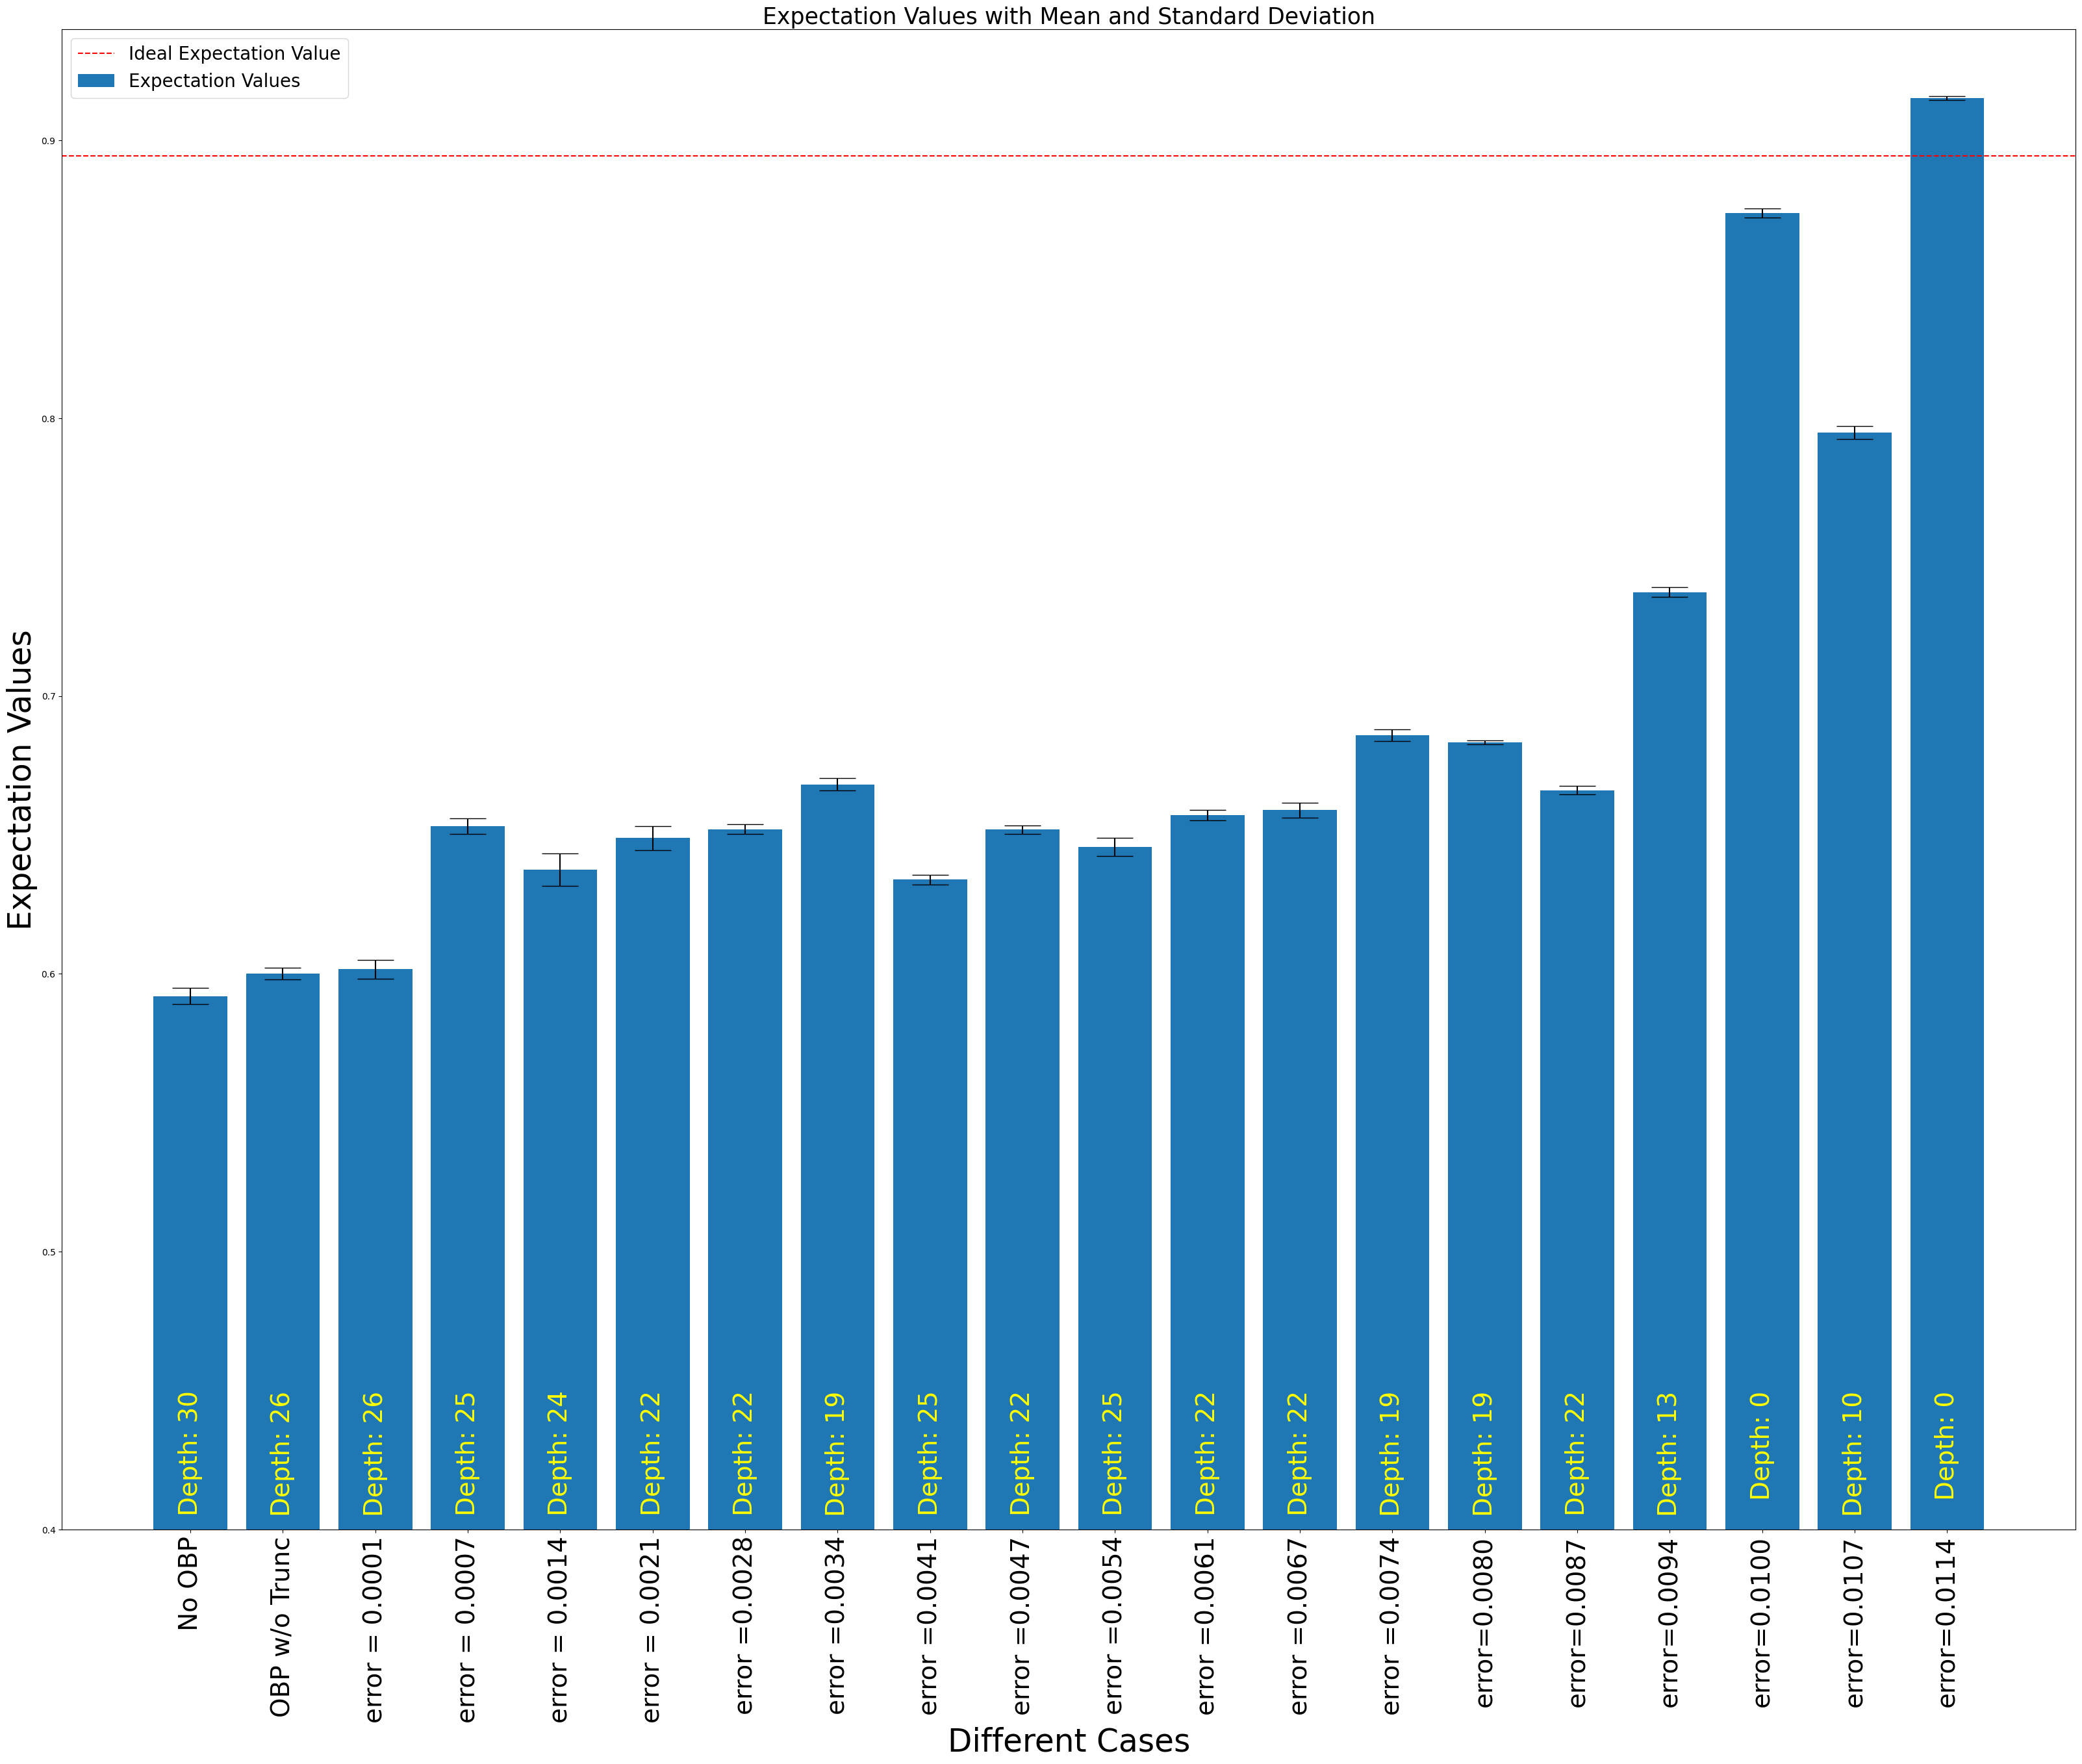

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

means = [np.mean(t) for t in exp_vals]
std_devs = [np.std(t) for t in exp_vals]
#print(means)

bar_lengths = means
error_bars = std_devs

#x_pos = np.arange(1, 23)
fig, ax = plt.subplots(figsize=(40,30))
labels=['No OBP', 'OBP w/o Trunc', 'error = 0.0001', 'error = 0.0007','error = 0.0014', 'error = 0.0021', 'error =0.0028', 'error =0.0034','error =0.0041','error =0.0047','error =0.0054','error =0.0061','error =0.0067','error =0.0074', 'error=0.0080', 'error=0.0087','error=0.0094','error=0.0100','error=0.0107','error=0.0114']
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90, fontsize=28)
x_pos = range(len(labels))  # same length as your data
ax.bar(x_pos, bar_lengths, yerr=error_bars, capsize=20, label='Expectation Values')
for i, depth in enumerate(truncated_circuit_depths):
    ax.text(x_pos[i], 0.45, f'Depth: {int(depth)}', ha='center', va='top', fontsize=28, color='yellow', rotation =90)
ax.set_xlabel("Different Cases", fontsize=35)
ax.set_ylabel("Expectation Values", fontsize=35)
ax.set_title("Expectation Values with Mean and Standard Deviation", fontsize=25)
# Adjust plot limits to avoid cutting off text
ax.set_ylim([0.4, 0.94])
plt.axhline(y=result_ideal, color='r', linestyle='--', label='Ideal Expectation Value')
plt.legend(fontsize=20)
plt.show()